# LSTM

In [1]:
#import packages
import numpy as np
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import random
import math
from datetime import datetime
import pickle
import pandas as pd
%matplotlib inline

#predefined activation function and its derivative
def Sigmoid(x): 
    return 1. / (1 + np.exp(-x))

def dSigmoid(values): 
    return values*(1-values)

def Tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def dtanh(values): 
    return 1. - values**2

def rand_arr(a, b, *args): 
    seed(0)
    return rand(*args)*(b - a) + a

#LSTM Class
class LSTM:
    def __init__(self, X_dim, y_dim, neuron):
        
        self.X_dim = X_dim 
        self.y_dim = y_dim
        self.neuron = neuron
        
        #initiate weight
        self.weight_f = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_i = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_g = rand_arr(-0.1, 0.1, neuron, X_dim + neuron) 
        self.weight_o = rand_arr(-0.1, 0.1, neuron, X_dim + neuron)
        self.weight_out = rand_arr(-0.1, 0.1, y_dim, neuron)
        
        #initiate bias
        self.bias_f = rand_arr(-0.1, 0.1, neuron) 
        self.bias_i = rand_arr(-0.1, 0.1, neuron) 
        self.bias_g = rand_arr(-0.1, 0.1, neuron) 
        self.bias_o = rand_arr(-0.1, 0.1, neuron)
        self.bias_out = rand_arr(-0.1, 0.1, y_dim)
    
    def forward(self, inputs, outputs):
        X = inputs
        y = outputs
        
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        #show error
        #print(np.array(self.error).mean())
    
    def backward(self, inputs, outputs):
        self.diff_out = []
        self.diff_h = []
        self.diff_h_bottom = [zeros(self.neuron)]
        self.diff_s_up = [zeros(self.neuron)]
        self.diff_s = []
        self.diff_o = []
        self.diff_g = []
        self.diff_i = []
        self.diff_f = []
        for i in range(len(inputs)-1,-1,-1):
            #derivate of output
            if i == len(inputs)-1:
                self.diff_out  = [2*(self.out[i] - outputs[i])] + self.diff_out
                self.diff_h = [self.diff_out[0]*dSigmoid(self.weight_out@self.h[i+1] + self.bias_out)*self.weight_out + self.diff_h_bottom[0]] + self.diff_h
            else:
                self.diff_h = [self.diff_h_bottom[0]] + self.diff_h
            
            
            #derivative of gate/neural network operation
            self.diff_s = [self.diff_h[0]*self.o[i]*dtanh(self.s[i+1]) + self.diff_s_up[0]] + self.diff_s
            self.diff_o = [self.diff_h[0]*Tanh(self.s[i+1])] + self.diff_o
            self.diff_g = [self.i[i]*self.diff_s[0]] + self.diff_g
            self.diff_i = [self.g[i]*self.diff_s[0]] + self.diff_i
            self.diff_f = [self.s[i]*self.diff_s[0]] + self.diff_f
            
            #derivative of concatenation of input dan previous output value
            self.dX_concat = (self.diff_o[0].T*(dSigmoid(self.o[i]).reshape(self.neuron,1))).T@self.weight_o
            self.dX_concat += (self.diff_g[0].T*(dSigmoid(self.g[i]).reshape(self.neuron,1))).T@self.weight_g
            self.dX_concat += (self.diff_i[0].T*(dSigmoid(self.i[i]).reshape(self.neuron,1))).T@self.weight_i
            self.dX_concat += (self.diff_f[0].T*(dSigmoid(self.f[i]).reshape(self.neuron,1))).T@self.weight_f
            
            #update value of long and short term memory
            self.diff_h_bottom = [self.dX_concat[-1][self.X_dim:]] + self.diff_h_bottom
            self.diff_s_up = [self.diff_s[0]*self.f[i]] + self.diff_s_up
            
    def update(self, alpha):
        
        #alpha 
        
        #update everyweight and bias
        self.weight_out -= alpha*self.diff_out[0].reshape(1,1)@self.h[1].T.reshape(1,self.neuron)
        self.bias_out -= alpha*self.diff_out[0]
        
        self.weight_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_f -= alpha*(self.diff_f[0]*dSigmoid(self.weight_f@self.X_concat[0] + self.bias_f)).reshape(self.neuron,)
        
        self.weight_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_i -= alpha*(self.diff_i[0]*dSigmoid(self.weight_i@self.X_concat[0] + self.bias_i)).reshape(self.neuron,)
        
        self.weight_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).T@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_g -= alpha*(self.diff_g[0]*dSigmoid(self.weight_g@self.X_concat[0] + self.bias_g)).reshape(self.neuron,)
        
        self.weight_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).T.reshape(self.neuron,1)@self.X_concat[0].reshape(1,self.X_dim + self.neuron)
        self.bias_o -= alpha*(self.diff_o[0]*dSigmoid(self.weight_o@self.X_concat[0] + self.bias_o)).reshape(self.neuron,)
    
    def predict(self, inputs, outputs):
        X = inputs
        y = outputs
        self.X = X
        self.y = y
        #make list to save the values of every unit 
        self.X_concat = []
        self.f = []
        self.i = []
        self.g = []
        self.o = []
        self.s = [zeros(self.neuron)] #first s input is 0
        self.h = [zeros(self.neuron)] #first h input is 0
        self.out = []
        self.error = []
        for i in range(len(inputs)):
            #forward for every unit
            X_concat = np.hstack((X[i],  self.h[i]))
            self.X_concat.append(X_concat)
            self.f.append(Sigmoid(self.weight_f@X_concat + self.bias_f))
            self.i.append(Sigmoid(self.weight_i@X_concat + self.bias_i))
            self.g.append(Tanh(self.weight_g@X_concat + self.bias_g))
            self.o.append(Sigmoid(self.weight_o@X_concat + self.bias_o))
            self.s.append(self.f[i]*self.s[i] + self.i[i]*self.g[i])
            self.h.append(Tanh(self.s[i+1])*self.o[i])
            self.out.append(self.weight_out@self.h[i+1] + self.bias_out)
            self.error.append(abs(self.out[-1] - y[i]))
        
        return [self.out[-1][0],self.y[-1]]
    
    def show_progress(self):
        return abs(self.y[-1][0] - self.out[-1])

## Change the Indicators Here!

In [2]:
#hyperparameters
nc      = 10 #units
epochs  = 10

#datasets
name_of_dataset = 'GGRM-long.csv'
column_dataset_obs = 'Close'

# Import Dataset

In [3]:
df = pd.read_csv('../../Datasets/'+name_of_dataset)
df.drop('Volume', inplace=True, axis=1)
df

Date     Open     High      Low    Close     Adj Close
0     2017-01-02  63900.0  63900.0  63900.0  63900.0  53824.429688
1     2017-01-03  63650.0  64350.0  63100.0  63300.0  53319.035156
2     2017-01-04  63400.0  64450.0  62300.0  63200.0  53234.804688
3     2017-01-05  63200.0  65600.0  63200.0  65600.0  55256.378906
4     2017-01-06  65450.0  65450.0  63900.0  64425.0  54266.652344
...          ...      ...      ...      ...      ...           ...
1257  2021-12-24  30625.0  30625.0  30500.0  30525.0  30525.000000
1258  2021-12-27  30525.0  30800.0  30475.0  30675.0  30675.000000
1259  2021-12-28  30675.0  30850.0  30650.0  30650.0  30650.000000
1260  2021-12-29  30800.0  30825.0  30650.0  30650.0  30650.000000
1261  2021-12-30  30675.0  30700.0  30550.0  30600.0  30600.000000

[1262 rows x 6 columns]

In [4]:
df.isna().sum()


Date         0
Open         1
High         1
Low          1
Close        1
Adj Close    1
dtype: int64

In [5]:
df = df.dropna()

In [6]:
df.describe()

Open           High           Low         Close     Adj Close
count   1261.000000    1261.000000   1261.000000   1261.000000   1261.000000
mean   60509.615385   61197.422680  59790.146709  60453.033307  54605.716865
std    17523.568490   17684.222558  17350.455959  17549.552357  14590.353188
min    30200.000000   30425.000000  29925.000000  30200.000000  30200.000000
25%    44050.000000   44675.000000  43150.000000  44000.000000  41154.226563
50%    65000.000000   65575.000000  64475.000000  64925.000000  55130.035156
75%    76375.000000   77025.000000  75650.000000  76375.000000  67817.664063
max    94300.000000  100975.000000  92600.000000  94400.000000  85359.835938

In [7]:
new_df = df.reset_index()[column_dataset_obs]
new_df

0       63900.0
1       63300.0
2       63200.0
3       65600.0
4       64425.0
         ...   
1256    30525.0
1257    30675.0
1258    30650.0
1259    30650.0
1260    30600.0
Name: Close, Length: 1261, dtype: float64

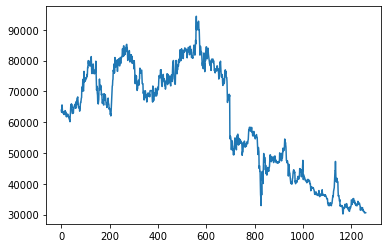

In [8]:
plt.plot(new_df)

# MinMax Scaler

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
new_df = scaler.fit_transform(np.array(new_df).reshape(-1,1))
new_df

array([[0.52492212],
       [0.51557632],
       [0.51401869],
       ...,
       [0.00700935],
       [0.00700935],
       [0.00623053]])

In [10]:
xs = new_df

In [11]:
#Standarized the dataset
N       = xs.shape[0]

#hypreparameter
Ts      = 1
x_dim   = 1
alpha   = 0.01 #learningrate

xt      = xs[0:N-x_dim,:]

for i in range(x_dim):
    xt  = hstack((xt, xs[i+1:N-x_dim+i+1]))   



# Splitting Training and Testing

In [12]:
training_size = int(len(new_df)*0.8)
test_size = len(new_df)-training_size

In [13]:
training_size, test_size

(1008, 253)

In [14]:
X_train = xt[:training_size, 0:x_dim]     
y_train = xt[:training_size, x_dim:x_dim+1]  
X_test = xt[-test_size:, 0:x_dim]     
y_test = xt[-test_size:, x_dim:x_dim+1]

## Build LSTM Model

In [15]:
me = LSTM(x_dim,1,nc)
for i in range(epochs):
    print('-------------',i+1,'-------------')
    for j in range(X_train.shape[0]-Ts):
        me.forward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.backward(X_train[j:j+Ts],y_train[j:j+Ts])
        me.update(alpha)
    hehe = []
    for j in range(X_test.shape[0]-Ts):
        me.forward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.backward(X_test[j:j+Ts],y_test[j:j+Ts])
        me.update(alpha)
        hehe.append(me.show_progress())    
    print(np.array(hehe).mean())

------------- 1 -------------
0.0450884485387832
------------- 2 -------------
0.04508826513268673
------------- 3 -------------
0.045088080324269905
------------- 4 -------------
0.04508789409061861
------------- 5 -------------
0.04508770639933764
------------- 6 -------------
0.04508751721762712
------------- 7 -------------
0.04508732651227372
------------- 8 -------------
0.045087134249640025
------------- 9 -------------
0.04508694039565558
------------- 10 -------------
0.04508674491580648
------------- 11 -------------
0.04508654777512537
------------- 12 -------------
0.045086348938180906
------------- 13 -------------
0.04508614836906739
------------- 14 -------------
0.045085946031393966
------------- 15 -------------
0.04508574188827372
------------- 16 -------------
0.0450855359023123
------------- 17 -------------
0.045085328035597
------------- 18 -------------
0.04508511824968458
------------- 19 -------------
0.04508490650559024
------------- 20 -------------
0.0450846

0.04499463023210902
------------- 162 -------------
0.04499297622308686
------------- 163 -------------
0.04499129102958637
------------- 164 -------------
0.04498957394924437
------------- 165 -------------
0.04498782426129102
------------- 166 -------------
0.044986041225993076
------------- 167 -------------
0.04498422408407771
------------- 168 -------------
0.04498237205613716
------------- 169 -------------
0.04498048434201226
------------- 170 -------------
0.04497856012015535
------------- 171 -------------
0.04497659854697068
------------- 172 -------------
0.0449745987561322
------------- 173 -------------
0.04497255985787734
------------- 174 -------------
0.04497048093827639
------------- 175 -------------
0.044968361058475854
------------- 176 -------------
0.04496619925391571
------------- 177 -------------
0.04496399453351833
------------- 178 -------------
0.044961745878849296
------------- 179 -------------
0.04495945224324806
------------- 180 -------------
0.04495711

0.04160662363579134
------------- 321 -------------
0.041496888734598184
------------- 322 -------------
0.041383417875178616
------------- 323 -------------
0.041266089604654964
------------- 324 -------------
0.041144779280562295
------------- 325 -------------
0.041019359007090174
------------- 326 -------------
0.040889697567148144
------------- 327 -------------
0.04075566035011644
------------- 328 -------------
0.040617109275328675
------------- 329 -------------
0.04047390271157982
------------- 330 -------------
0.040325895393264116
------------- 331 -------------
0.040172938334140464
------------- 332 -------------
0.040014878740201286
------------- 333 -------------
0.03985155992369694
------------- 334 -------------
0.03968282122105202
------------- 335 -------------
0.039508497918207666
------------- 336 -------------
0.03932842118784484
------------- 337 -------------
0.03914241804399084
------------- 338 -------------
0.03895031132068622
------------- 339 -------------
0

0.006642213851776091
------------- 477 -------------
0.006638205128829915
------------- 478 -------------
0.006634536704611698
------------- 479 -------------
0.006631034054795931
------------- 480 -------------
0.006627980746682341
------------- 481 -------------
0.006625554506645119
------------- 482 -------------
0.006623453787734194
------------- 483 -------------
0.006621497618968814
------------- 484 -------------
0.006619833691034858
------------- 485 -------------
0.006618248091231365
------------- 486 -------------
0.006616851286075204
------------- 487 -------------
0.006615706433997185
------------- 488 -------------
0.0066146933588314425
------------- 489 -------------
0.006613731111454266
------------- 490 -------------
0.00661285134390924
------------- 491 -------------
0.006612171139294854
------------- 492 -------------
0.006611526587243069
------------- 493 -------------
0.006610965727832666
------------- 494 -------------
0.006610528129956231
------------- 495 -------

0.006618683776044195
------------- 632 -------------
0.006618883058827242
------------- 633 -------------
0.0066190805604111405
------------- 634 -------------
0.006619276290442746
------------- 635 -------------
0.006619470258824015
------------- 636 -------------
0.0066196624756953
------------- 637 -------------
0.006619852951418974
------------- 638 -------------
0.006620041696563819
------------- 639 -------------
0.006620228721890415
------------- 640 -------------
0.006620414038336639
------------- 641 -------------
0.006620597657004327
------------- 642 -------------
0.006620779589146208
------------- 643 -------------
0.006620959846153453
------------- 644 -------------
0.0066211384395439945
------------- 645 -------------
0.006621315380951089
------------- 646 -------------
0.006621490682112602
------------- 647 -------------
0.006621664354860698
------------- 648 -------------
0.006621836411111985
------------- 649 -------------
0.0066220068628582976
------------- 650 ------

0.006637307851093385
------------- 788 -------------
0.006637372663149789
------------- 789 -------------
0.006637436871200918
------------- 790 -------------
0.006637500481250688
------------- 791 -------------
0.006637563499242706
------------- 792 -------------
0.006637625931060653
------------- 793 -------------
0.006637687782529197
------------- 794 -------------
0.006637749059414286
------------- 795 -------------
0.006637811486249406
------------- 796 -------------
0.006637876442412704
------------- 797 -------------
0.006637940795740034
------------- 798 -------------
0.006638004552218067
------------- 799 -------------
0.006638067717773159
------------- 800 -------------
0.006638130298272162
------------- 801 -------------
0.00663819229952283
------------- 802 -------------
0.006638253727274744
------------- 803 -------------
0.0066383145872193315
------------- 804 -------------
0.00663837488499106
------------- 805 -------------
0.006638434626167688
------------- 806 --------

0.006643158130067471
------------- 944 -------------
0.0066431768371985975
------------- 945 -------------
0.006643195398403387
------------- 946 -------------
0.006643213815107572
------------- 947 -------------
0.0066432320887226904
------------- 948 -------------
0.006643250220646573
------------- 949 -------------
0.006643268212263121
------------- 950 -------------
0.006643286064942648
------------- 951 -------------
0.006643303780041946
------------- 952 -------------
0.006643321358904468
------------- 953 -------------
0.006643338802860414
------------- 954 -------------
0.006643356113226846
------------- 955 -------------
0.006643373291307939
------------- 956 -------------
0.006643390338394926
------------- 957 -------------
0.0066434072557663175
------------- 958 -------------
0.0066434240446881345
------------- 959 -------------
0.006643440706413846
------------- 960 -------------
0.006643457242184593
------------- 961 -------------
0.006643473653229273
------------- 962 ---

In [16]:
import matplotlib.pyplot as plt

out = []
for j in range(X_test.shape[0]-Ts):
    out.append(me.predict(X_test[j:j+Ts],y_test[j:j+Ts]))

out=scaler.inverse_transform(out).tolist()

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## Report Performance of LSTM Predictions

In [17]:
from math import sqrt

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

In [18]:
# mse = mean_squared_error(y, predictions)
# print('MSE: '+str(mse))
rmse = math.sqrt(mean_squared_error(np.array(out)[:,1], np.array(out)[:,0]))
print('RMSE: '+ str("{:.2f}".format(rmse)))
mae = mean_absolute_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAE: '+ str("{:.2f}".format(mae)))
mape = mean_absolute_percentage_error(np.array(out)[:,1], np.array(out)[:,0])
print('MAPE: '+ str("{:.2f}".format(mape*100)) + '%')

RMSE: 669.73
MAE: 438.30
MAPE: 1.21%


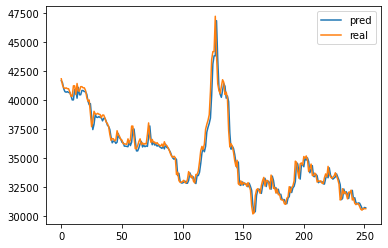

In [19]:
plt.plot(np.array(out)[:,0],label = 'pred')
plt.plot(np.array(out)[:,1],label = 'real')
plt.legend()

In [20]:
len(out)

252